# **Protein Language Models (Intuition): A First Look at Modeling Syntax and Semantics of the Known  Protein Universe**


By Dhuvi Karthikeyan, Aaron Menezes, Elisa Gómez de Lope, and Rakshit Singh

Inspired by the success of Large Language Models (LLMs) such as BERT, T5, and GPT, that have demonstrated state of the art performance on sentiment analysis, summarization, question answering, and classification tasks, protein language models (pLMs) have demonstrated similar sweeping success across a broad array of protein specific tasks. These tasks include contact prediction, mutational landscape fitness prediction, binding site prediction, property prediction, and much more! In this tutorial, we explore the fundamental intuition driving the success of protein language models, by developing a strong intuition of what is actually happening under the hood and the resulting pros and cons of their usage. If you'd like to learn more about language models in various other domains, check out DeepChem's very own ChemBERTa, a large language model trained on the chemical domain [here](https://deepchem.io/tutorials/transfer-learning-with-chemberta-transformers/).


<a target="_blank" href="https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/ProteinLM_Tutprial0.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

#### Table of Contents:
1. [Introduction](#introduction)
2. [What is a language model?](#what-is)
3. [Methods for learning language](#methods)
4. [How do Protein Language Models (pLMs) work?](#how-to)
5. [MSA-aware vs non-MSA-aware protein language models](#msa)
6. [Evolutionary statistics of Hemoglobin 𝛽 and its ProtBERT learned representation](#hemoglobin)
7. [Concluding thoughts](#conclusion)


## **1. Introduction** <a name="introduction"></a>

This DeepChem tutorial is designed to serve as an introductory primer on protein language models, a powerful and versatile method of processing protein sequence information inspired by methods from the natural language space. Over the past decade, natural language processing has shown the strength of using learned representations to encapsulate the semantic meaning of text data. Notable models like word2vec [[1]](https://arxiv.org/abs/1301.3781) and GloVe [[2]](https://aclanthology.org/D14-1162/) proved that self-supervised pre-training on large, unlabeled corpora effectively creates robust feature embeddings that maintain similarity and analogy in language. However, these models were limited in utility by their context-free embeddings. The advent of context-aware models, starting with BERT [[3]](https://aclanthology.org/N19-1423/), led to numerous sequence models applicable beyond language domains. In biology, self-supervised pre-training on protein language models has achieved state-of-the-art performance in various tasks by deriving context-aware amino acid embeddings that can be finteuned to capture information on structure [[4]](https://www.biorxiv.org/content/10.1101/2020.12.15.422761v1) and function [[5]](https://www.biorxiv.org/content/early/2023/08/24/2023.08.23.554486.full.pdf) of proteins.

This tutorial aims to provide an overview of the concepts and intuition of protein language models that are needed to work with them and understand their input/outputs, strengths, failure modes. We skip over the detailed breakdown of their architecture, but invite the community to add content as they see fit in the form of a pull request to build upon this.

**Disclaimer**: For brevity sake, we make some assumptions with familiarity to the multi-layered perceptron, neural networks, and learning by gradient descent. Additionally we assume some fluency with probability theory on matters such as discrete vs. continuous distributions, likelihood, and conditional distributions. We provide links on non-obvious topics and concepts to external sources wherever necessary to bring the audience a vetted and beginner friendly source to start learning on the more complicated topics. Follow along for a high-level overview into the reason that protein language models have been so successful across a broad range of tasks.

## **2. What is a language model?**<a name="what-is"></a>

Under the hood, all language models are nothing more than probability distributions over tokens, or discrete sub-sequences. In natural language, a very intuitive set of tokens are the words of a language, or perhaps even the characters. Both have their own pros and cons. For simplicity, let's work with words as tokens here, though this changes for proteins. Since the learned distribution is over discrete units (words), this distribution is a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution), not a [continuous](https://en.wikipedia.org/wiki/Probability_distribution) one. To make this more concrete, take for example a common language model that you have likely interacted with many times in your life: text auto-complete. Text auto-complete is a conditional language model that takes the previous words you have written and then computes the [conditional probability](http://www.stat.yale.edu/Courses/1997-98/101/condprob.htm) over all the words in its vocabulary and returns the highest probability words based on the context. If you'd like a very intuitive and fine-grained explanation for both the form and function of language models, the 3Blue1Brown [walk-through](https://www.3blue1brown.com/lessons/gpt) is a great resource that breaks down the basics of the architecture, the flow of information, and the process of training a specific LLM (GPT). In this section we skip over the architecture of the language models and instead leave them as a black-box, focusing more on the how language models learn from sequences to better motivate their use in the protein domain.

A simple way to visualize what a language model is doing in the background is to think of the language model as updating and indexing a huge square matrix of [transition probabilities](https://en.wikipedia.org/wiki/Stochastic_matrix) of size $D x D$, where $D$ is the vocabulary size of the model. Here vocabulary size refers to the number of unique words or sub-words that make up the state space of the categorical distribution. So a model that only knows the words ['a', 'boy', 'cute', 'is', 'student', 'the' 'walking'] has a vocabulary size of 7. If we start off with an untrained model that is randomly initialized, we can use a [uniform](https://www.investopedia.com/terms/u/uniform-distribution.asp) initialization we would get a transition matrix that looks something like this where we introduce a special word to designate the end of sequence (EOS):

|         | a    | boy  | cute | is   |student| the     | walking | EOS |
|---------|------|------|------|------|-------|---------|---------|-----|
| a       | 0.125| 0.125| 0.125| 0.125| 0.125 | 0.125   | 0.125   |0.125|
| boy     | 0.125| 0.125| 0.125| 0.125| 0.125 | 0.125   | 0.125   |0.125|
| cute    | 0.125| 0.125| 0.125| 0.125| 0.125 | 0.125   | 0.125   |0.125|
| is      | 0.125| 0.125| 0.125| 0.125| 0.125 | 0.125   | 0.125   |0.125|
| student | 0.125| 0.125| 0.125| 0.125| 0.125 | 0.125   | 0.125   |0.125|
| the     | 0.125| 0.125| 0.125| 0.125| 0.125 | 0.125   | 0.125   |0.125|
| walking | 0.125| 0.125| 0.125| 0.125| 0.125 | 0.125   | 0.125   |0.125|


However, if we look at some of the transition probabilities, we can immediately see that the model is not very good. For example, the probability of the word 'a' coming after 'a' should be close to 0. Same goes for the word 'the' coming after 'a'. It's pretty clear that we need some way of training this model so that we can get some realistic transition probabilities. 

## **3. Methods for learning language**<a name="methods"></a>



#### 3.1 Causal Modeling

The first language models were trained on the principle of [causal language modeling](https://huggingface.co/docs/transformers/en/tasks/language_modeling), where the model is tasked with next word prediction during each training step.

$$\text{The quick brown fox jumped over the lazy -----.}$$
$$ P(x_t|x_{<t}) = ? $$

After enough rounds of this training protocol the model learns a much more plausible distribution over the words - something that looks like the following:

|         | a    | boy  | cute | is   |student |  the  | walking| EOS  |
|---------|------|------|------|------|---------|-------|--------|-----|
| a       | 0.0  | 0.5  | 0.1  | 0.05 | 0.25    | 0.05  |0.05    | 0.0 |
| boy     | 0.15 | 0.0  | 0.1  | 0.4  | 0.05    | 0.15  |.05     | 0.1 |
| cute    | 0.05 | 0.2  | 0.0  | 0.1  | 0.25    | 0.1   |0.0     | 0.3 |
| is      | 0.2  | 0.0  | 0.3  | 0.0  | 0.0     | 0.2   |0.3     | 0.0 |
| student | 0.15 | 0.05 | 0.1  | 0.5  | 0.0     | 0.05  |.05     | 0.1 |
| the     | 0.0  | 0.5  | .2   | 0.0  | 0.25    | 0.0   |0.05    | 0.0 |
| walking | 0.1   | .0   | .05  | .2   | .05    | 0.35 |0.0      | 0.3 |
| EOS     | 0.0  | 0.0   | 0.0 | 0.0   | 0.0    | 0.0   | 0.0    | 1.0 |

Here we can see that the model has learned that the words above are not typically repeated twice in a row. It assigns subject words ['boy', 'student'] after the word 'the' with higher probability than the verbs ['is', 'walking']. If we start at 'the' and sample the most likely words at each transition we can generate the following sentence as a path through the model: 'the' -> 'boy' -> 'is' -> 'walking' -> 'EOS'. This mode of sampling a word at every time step and then conditioning on the previously sampled words is known as auto-regressive generation.


#### 3.2 The Power of Neural Networks


A key point here that motivates the use of increasingly complicated neural networks for language modeling tasks is that with our illustrative example, we have the transition probability matrix and each step we sample from it like a [markov chain](https://en.wikipedia.org/wiki/Markov_chain). However, there are longer range dependencies in language that are not captured simply by conditioning on the previous word. So why not construct matrices that map transition probabilities between pairs of words or triples, or even more? Beyond issues of computational feasibility, this model would require that all possible n-grams would have been seen at least once during training, which greatly limits the models learning and usability. Neural networks have emerged as a great way of using large contexts and generating a neural representation of the sequence before indexing a loose transition matrix that maps between the neural representation and all the words in the vocabulary. For this reason, we often see in the language model space the distribution over the vocabulary from the last layer of a neural network as a one-dimensional probability distribution rather than a probability matrix. Keeping this in mind, we can see how these language models accommodate another method of learning language that draws from the context before **AND** after a word.


#### 3.3 Masked Language Modeling




Causal language modeling has a key drawback in that sometimes the necessary context to make sense of a word in a sentence comes after the word and not before. Masked language modeling is like causal modeling, but makes use of the fact that context may come before and after the word of interest.

$$\text{The quick brown [MASK] jumped over the lazy dog.}$$
$$ P(x_t|x_{! t}) = ??$$

This approach is what underlies the powerful BERT [[3]](https://arxiv.org/pdf/1810.04805) language model, where they used a masking rate of about 15\% of the words. Amazingly, this approach has been tried on sequences other than language and has been shown to be a robust model for learning the syntax and semantics of sequential data of various modalities including time series data, videos, and yes even proteins!

## **4. How do Protein Language Models (pLMs) work?**<a name="how-to"></a>



Inspired by the success of [large language models (LLMs)](https://magazine.sebastianraschka.com/p/understanding-large-language-models) in a broad variety of natural language tasks, protein language models represent a powerful new approach in understanding the syntax and semantics of protein sequences [[6]](https://arxiv.org/abs/2007.06225). These models are trained on using the masked language modeling objective to mask out portions of the sequence and infer what amino acids belong across billions of protein sequences, learning to identify patterns and relationships within the sequences that are crucial for their structure and function. This step is called pre-training and it imbues the language model with a general understanding of the structural dependencies within the language, in this case proteins.

An optional second training step known as [fine-tuning](https://medium.com/@bijit211987/the-evolution-of-language-models-pre-training-fine-tuning-and-in-context-learning-b63d4c161e49) can be applied on a pre-trained protein language model, to further train it on a specific task with protein sequence examples annotated with labels. In practice, starting from the pretrained weights has shown to have better performance than starting from randomly initialized weights as the model simply learns how to use strong representations of the inputs (learned during pretraining) instead of jointly learning the representation AND how to use it.  PLMs finetuned on the mappings between specific protein families or functional classes can significantly enhance predictive power compared to non-pretrained models, and can be applied in a number of different use cases, such as predicting binding sites or the effects of mutations.


One of the most compelling benefits of PLMs is their ability to capture coevolutionary relationships within and across protein sequences [[7]](https://www.biorxiv.org/content/10.1101/2024.01.30.577970v1.full.pdf). In the same way that words in a sentence co-occur to convey coherent meaning, amino acid residues in a protein sequence co-evolve to maintain the protein's structural integrity and functionality. PLMs capture these coevolutionary patterns, allowing for the prediction of how changes in one part of a protein may affect other parts. Thus, from a design perspective, the directed evolution task is an area where PLMs offer substantial advantages. In a directed evolution experiment, a naturally occurring protein can be mutated according to any arbitrary heuristic and is then checked if a desired function has improved. Since PLMs capture intra-sequence conditional distributions, this process can be vastly streamlined by masking portions of the protein we wish to 'mutate' and sampling from the distribution of what amino acids are strong candidates to occur given the rest of the sequence. PLMs thus have the potential to significantly reduce experimental burden by identify promising candidates a higher hit rate.



#### 4.1 Reconciling Sequence and Structure

Some protein language models combine in their training input amino acid sequence data with structural data, such as 3D coordinates of atoms in the protein. The goal is to explicitly incorporate structural information information, aiming to enhance the representation and ultimately prediction of unseen protein structure and functions. This is in contrast to sequence-only models that implicitly model structure which is more closely conserved across proteins via homology.

Models like ESM-1b [[4]](https://www.biorxiv.org/content/10.1101/2020.12.15.422761v1.full.pdf) and ESM-2 [[8]](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v3) are examples of sequence-only pLMs that do not explicitly incorporate 3D structural information. These sequence-based pLMs have demonstrated impressive performance on a variety of protein function prediction tasks by learning patterns from large protein sequence datasets.
However, the lack of structural information can limit the generalization capabilities of sequence-only PLMs. This is true especially for applications heavily dependent on protein structure such as contact prediction. Moreoever, the inclusion of structural information helps overcome the distributional biases that exist in the training datasets of sequences.

Structure-aware pLMs like S-PLM[[9]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10441326/) and ESM-Fold [[8]](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v3) are trained on both sequence and structural information, and in turn generate protein representations that encode both sequence and structural information. These models use various methods such as multi-view contrastive learning to align the sequence and structure representations in a shared latent space (S-PLM). The structural awareness enables them to achieve comparable or superior performance to specialized structure-based methods or sequence-based pLMs, particularly for applications that heavily rely on protein structure.

Interestingly, the recently released ESM-3 [[10]](https://www.evolutionaryscale.ai/blog/esm3-release) pLM reasons over sequence, structure, and function, meaning that for each protein, its sequence, structure, and function are extracted, tokenized, and partially masked during pre-training.

![image.png](https://www.biorxiv.org/content/biorxiv/early/2024/05/13/2023.08.06.552203/F1.large.jpg?width=800&height=600&carousel=1)
*The framework of S-PLM and lightweight tuning strategies for downstream supervised learning. a, The framework of S-PLM: During pretraining, the model inputs both the amino acid sequences and contact maps derived from protein structures simultaneously. After pretraining, the ESM-Adapter that generates the AA-level embeddings before the projector layer is used for downstream tasks. The entire ESM-Adapter model can be fully frozen or learnable through lightweight tuning. b, Architecture of the ESM-Adapter. c, Adapter tunning for supervised downstream tasks. d, LoRA tuning for supervised downstream tasks is implemented. Adapted from [[9]](https://www.biorxiv.org/content/10.1101/2023.08.06.552203v3).*



## **5. MSA-aware vs non-MSA-aware protein language models**<a name="msa"></a>



Multiple Sequence Alignment (MSA) is a method used to align three or more biological sequences (protein or nucleic acid) to identify regions of similarity that may indicate functional, structural, or evolutionary relationships. MSAs are a cornerstone in bioinformatics for tasks such as phylogenetic analysis, structure prediction, and function annotation.

In the context of pLMs, MSA provides evolutionary context to the representations of protein sequences. PLMs can be MSA-aware and non-MSA-aware:


#### **MSA-aware models:**



MSA-aware models, such as the MSA Transformer [[11]](https://proceedings.mlr.press/v139/rao21a.html), Evoformer (used in AlphaFold) [[12]](https://www.nature.com/articles/s41586-021-03819-2) and ESM-MSA [[11]](https://proceedings.mlr.press/v139/rao21a.html), are trained on datasets that include MSAs as input to incorporate evolutionary information and relationships between sequences to learn richer representations. They align multiple homologous sequences to capture conserved and variable regions. The rationale is that conserved regions often indicate functionally or structurally important parts of the protein, while variable regions can provide insights into evolutionary divergence and adaptation.

MSA-aware models can provide deeper insights into protein function and structure due to the evolutionary context. However, they are computationally intensive and require high-quality MSAs, which may not be available for all protein families.


#### **Non-MSA-aware models:**



Non-MSA-aware models, such as ESMFold (ESM-2)[[8]](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v3), ProtBERT [[6]](https://arxiv.org/abs/2007.06225) and TAPE, treat each protein sequence independently and do not explicitly incorporate evolutionary information from MSAs. They are trained on large datasets of individual protein sequences, learning patterns and representations directly from the sequence data.

While they can generalize well to diverse sequences and are computationally efficient, they may miss out on the evolutionary context that can be crucial for certain tasks.

<img src="https://cdn.prod.website-files.com/621e95f9ac30687a56e4297e/64a8d21628b03e0f9f71a4fc_V2_1677884143661_5f927638-5fb9-40ac-9301-8f25c3bcf649.png" alt="image.png" width="800">

"*Multiple Sequence Alignment". BioRender.*



#### **Benefits and challenges of MSA-aware models:**



- Evolutionary insight: MSAs provide evolutionary information, highlighting conserved residues that are often critical for protein function and structure.
- Improved predictions: By incorporating evolutionary context, MSA-aware models can improve performance on tasks such as secondary structure prediction, contact prediction, and function annotation.
- Functional and structural understanding: MSAs help in identifying functionally important regions and understanding the structural constraints of proteins.
- Computational complexity: Generating and processing MSAs is computationally expensive and time-consuming.
- Data availability: High-quality MSAs are not available for all protein families, especially those with few known homologs.
- Model complexity: MSA-aware models are more complex and require sophisticated architectures to effectively utilize the evolutionary information.



Other considerations:
- The performance benchmark of both MSA-aware and not MSA-aware for predicting the 3D structure of proteins, as well as their function and other properties is currently an active topic of research.
- Interestingly, MSA-free models have reported ability to efficiently generate sufficiently accurate MSAs that can be used as input for the MSA-aware models.




#### Without further ado, lets explore some of the properties of protein language models in the wild!


## **6. Evolutionary statistics of Hemoglobin 𝛽 and its ProtBERT learned representation**<a name="hemoglobin"></a>




![hemoglobin.png](https://www.researchgate.net/profile/Lakna-Panawala/publication/313841668/figure/fig1/AS:463461898559488@1487509335507/Structure-of-Hemoglobin.png)

Image Source: *Adapted from "Représentation simplifiée de l'hémoglobine et de l'hème". Wikimedia Commons.*


Hemoglobin is the protein responsible for transporting oxygen from the lungs to all the cells of our body via red blood cells. Hemoglobin is a great protein to interrogate the behaviors of protein language models as it is highly conserved in certain regions across species, and also slightly variable in other places. What would we expect the distribution over amino acids to look like if we mask out a highly conserved region? What about a highly diverse region? Let's find out.


**Hemoglobin Sequence Homology across closely related mammals** (from [[13]](https://www.nature.com/articles/s41598-019-50619-w)):



In [ ]:
hemoglobin_beta = {
'human':
"MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH",
'chimpanzee':
"MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTORFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH",
'camel':
"MVHLSGDEKNAVHGLWSKVKVDEVGGEALGRLLVVYPWTRRFFESFGDLSTADAVMNNPKVKAHGSKVLNSFGDGLNHLDNLKGTYAKLSELHCDKLHVDPENFRLLGNVLVVVLARHFGKEFTPDKQAAYQKVVAGVANALAHRYH",
'rabbit':
"MVHLSSEEKSAVTALWGKVNVEEVGGEALGRLLVVYPWTQRFFESFGDLSSANAVMNNPKVKAHGKKVLAAFSEGLSHLDNLKGTFAKLSELHCDKLHVDPENFRLLGNVLVIVLSHHFGKEFTPQVQAAYQKVVAGVANALAHKYH",
'pig':
"MVHLSAEEKEAVLGLWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSNADAVMGNPKVKAHGKKVLQSFSDGLKHLDNLKGTFAKLSELHCDQLHVDPENFRLLGNVIVVVLARRLGHDFNPNVQAAFQKVVAGVANALAHKYH",
'horse':
"*VQLSGEEKAAVLALWDKVNEEEVGGEALGRLLVVYPWTQRFFDSFGDLSNPGAVMGNPKVKAHGKKVLHSFGEGVHHLDNLKGTFAALSELHCDKLHVDPENFRLLGNVLVVVLARHFGKDFTPELQASYQKVVAGVANALAHKYH",
'bovine':
"M**LTAEEKAAVTAFWGKVKVDEVGGEALGRLLVVYPWTQRFFESFGDLSTADAVMNNPKVKAHGKKVLDSFSNGMKHLDDLKGTFAALSELHCDKLHVDPENFKLLGNVLVVVLARNFGKEFTPVLQADFQKVVAGVANALAHRYH",
'sheep':
"M**LTAEEKAAVTGFWGKVKVDEVGAEALGRLLVVYPWTQRFFEHFGDLSNADAVMNNPKVKAHGKKVLDSFSNGMKHLDDLKGTFAQLSELHCDKLHVDPENFRLLGNVLVVVLARHHGNEFTPVLQADFQKVVAGVANALAHKYH"
}


As we can see there is a great degree of overlap between the hemoglobin $\beta$ subunits across the animal kingdom. The part of the hemoglobin sequence that is essential to the function of carrying oxygen is the part that binds to the heme group. This is handled by a single amino acid, namely the Histidine (H) near position 92 on the beta chain, in the middle of the underlined subsequences above. Unsurprsingly, given its functional importance, the amino acid (H) at position is unchanged across all species. Can a language model recapitulate this?

### **ProtBERT learned representation of Hemoglobin 𝛽**

ProtBERT [[6]](https://arxiv.org/abs/2007.06225) is a BERT style protein language model that was trained via masked amino acid modeling on Uniref100 [[14]](https://doi.org/10.1093/bioinformatics/btm098), a dataset consisting of 217 million protein sequences, and 88B amino acids. The Uniref database contains deduplicated protein sequences from UniProt where they are clustered together, and thus deduplicated, given the threhold of sequence identity between species. Uniref100 takes 100% sequence identity, while Uniref90 does 90% and Uniref50% has a cutoff of 50%. As such, ProtBERT was trained on the largest of these databases. Lets load up ProtBERT and see what it looks like.

In [ ]:
### Step 1. Download ProtBERT Weights from the HF repo
from transformers import BertForMaskedLM, BertTokenizer, pipeline
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertForMaskedLM.from_pretrained("Rostlab/prot_bert")
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-29): 30 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [ ]:
### Step 2. Mask the F8 Histidine of Hemoglobin B Subunit
human_heme = list(hemoglobin_beta['human'])
human_heme[92] = "[MASK]"
masked_heme = ' '.join(human_heme)
print(masked_heme)

M V H L T P E E K S A V T A L W G K V N V D E V G G E A L G R L L V V Y P W T Q R F F E S F G D L S T P D A V M G N P K V K A H G K K V L G A F S D G L A H L D N L K G T F A T L S E L [MASK] C D K L H V D P E N F R L L G N V L V C V L A H H F G K E F T P P V Q A A Y Q K V V A G V A N A L A H K Y H


In [ ]:
### Step 3. Tokenize the Sequence
tokenized_sequence = tokenizer(masked_heme, return_tensors='pt')
tokenized_sequence

{'input_ids': tensor([[ 2, 21,  8, 22,  5, 15, 16,  9,  9, 12, 10,  6,  8, 15,  6,  5, 24,  7,
         12,  8, 17,  8, 14,  9,  8,  7,  7,  9,  6,  5,  7, 13,  5,  5,  8,  8,
         20, 16, 24, 15, 18, 13, 19, 19,  9, 10, 19,  7, 14,  5, 10, 15, 16, 14,
          6,  8, 21,  7, 17, 16, 12,  8, 12,  6, 22,  7, 12, 12,  8,  5,  7,  6,
         19, 10, 14,  7,  5,  6, 22,  5, 14, 17,  5, 12,  7, 15, 19,  6, 15,  5,
         10,  9,  5,  4, 23, 14, 12,  5, 22,  8, 14, 16,  9, 17, 19, 13,  5,  5,
          7, 17,  8,  5,  8, 23,  8,  5,  6, 22, 22, 19,  7, 12,  9, 19, 15, 16,
         16,  8, 18,  6,  6, 20, 18, 12,  8,  8,  6,  7,  8,  6, 17,  6,  5,  6,
         22, 12, 20, 22,  3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
### Step 4. Pass the tokenized sequence through ProtBERT
model_outs = model(**tokenized_sequence)
model_outs

MaskedLMOutput(loss=None, logits=tensor([[[-18.5725, -18.4833, -18.4627,  ..., -18.6075, -18.6886, -18.5834],
         [-19.9242, -21.0844, -20.1253,  ..., -18.1157, -19.4804, -19.9197],
         [-17.1929, -18.2174, -17.2419,  ..., -18.0640, -17.8393, -17.1908],
         ...,
         [-19.3707, -19.7466, -19.2460,  ..., -21.4760, -20.1202, -22.1149],
         [-19.6403, -20.1926, -18.5551,  ..., -17.4572, -18.9988, -21.0471],
         [-18.8277, -19.8305, -18.5255,  ..., -16.8518, -18.2768, -18.0429]]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [ ]:
### Step 5. Transform the Logits
import torch.nn.functional as F
logits = model_outs.logits.squeeze()[1:-1] # Ignore SOS and EOS special tokens
print(logits.shape)
softmaxed = F.softmax(logits, dim=1).detach().numpy() # Softmax to normalize the logits to sum to 1

torch.Size([147, 30])


In [ ]:
### Step 6. Decode the Logits Using Greedy Decoding (Max Probability at Each Timestep)
decoded_outputs = tokenizer.batch_decode(softmaxed.argmax(axis=1))
decoded_sequence = ''.join(decoded_outputs)
print(decoded_sequence)
print(f'The filled-in masked sequence is: {decoded_sequence[92]}')

MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLKHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH
The filled-in masked sequence is: H


**Sanity Check:** Whew, looks like the pLM ProtBERT was able to recapitulate the correct amino acid at that position. But how confident was the model? Let's visualize the distribution at that position and see what other amino acids the  model was choosing between.



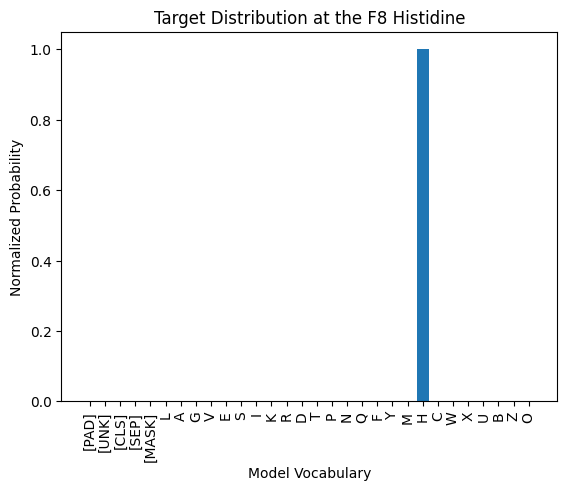

In [ ]:
### Step 7. Visualize the Token Distribution at the F8 Histidine
import matplotlib.pyplot as plt

plt.bar(tokenizer.get_vocab().keys(), softmaxed[92])
plt.ylabel('Normalized Probability')
plt.xlabel('Model Vocabulary')
plt.title('Target Distribution at the F8 Histidine')
plt.xticks(rotation='vertical')
plt.show()

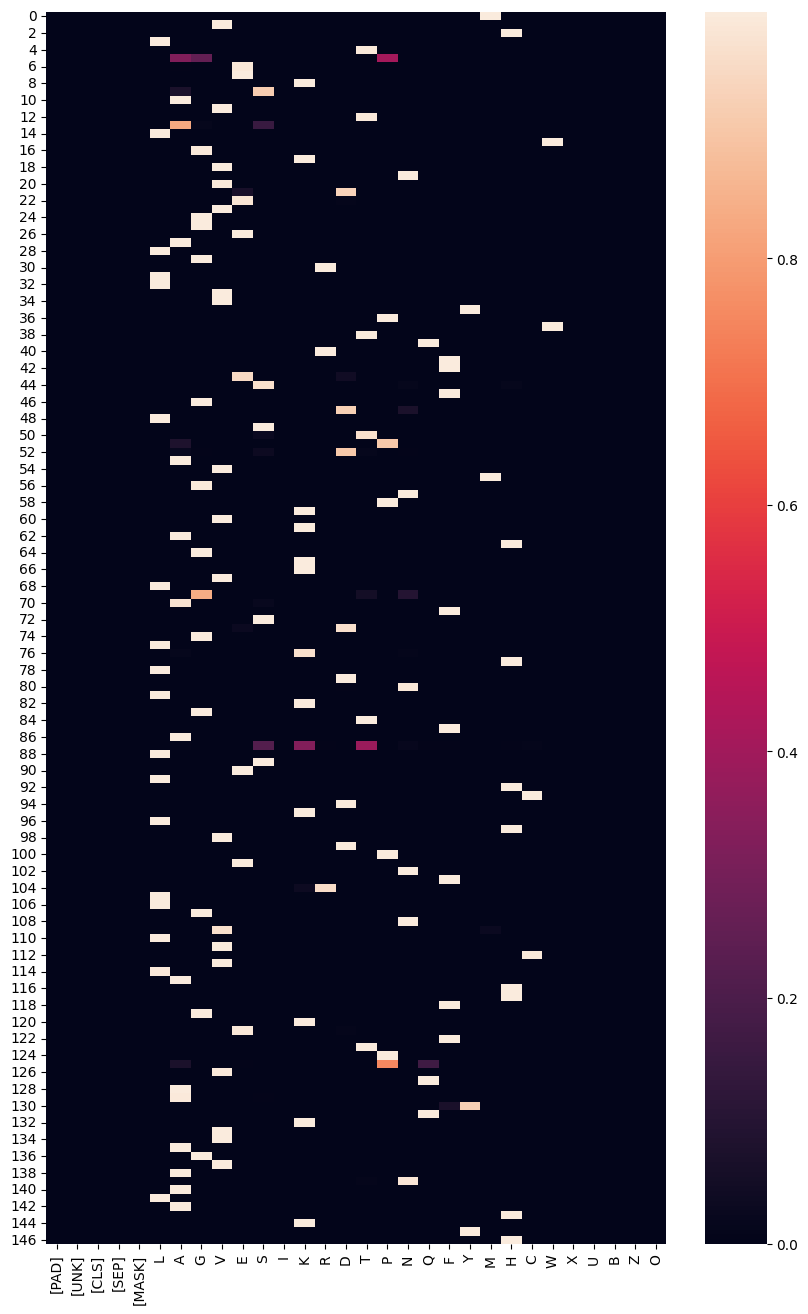

In [ ]:
### [EXTRA] Step 8. Visualize the Logits Map Across All Positions
import seaborn as sns

plt.figure(figsize=(10,16))
sns.heatmap(softmaxed, xticklabels=tokenizer.get_vocab())
plt.show()

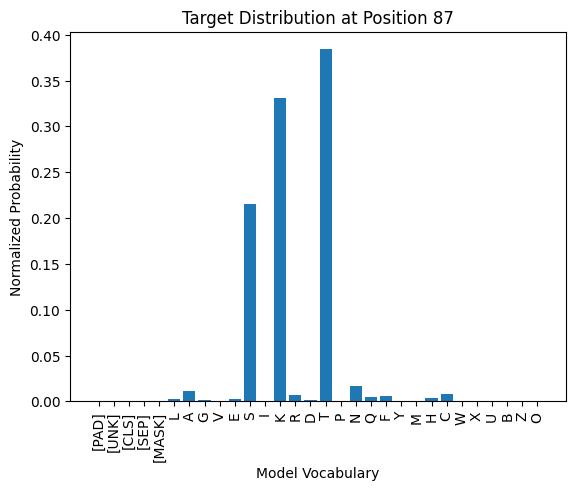

In [ ]:
### [EXTRA] Step 9. Look at a Low Confidence Region

plt.bar(tokenizer.get_vocab().keys(), softmaxed[87])
plt.ylabel('Normalized Probability')
plt.xlabel('Model Vocabulary')
plt.title('Target Distribution at Position 87')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
for animal in hemoglobin_beta:
    print(f'{animal} has residue {hemoglobin_beta[animal][87]} at position 87')

human has residue T at position 87
chimpanzee has residue T at position 87
camel has residue K at position 87
rabbit has residue K at position 87
pig has residue K at position 87
horse has residue A at position 87
bovine has residue A at position 87
sheep has residue Q at position 87


As we can see from the above, at the positions where is lower confidence, there tends to be an increase in diversity among the different species. This aligns well with out understanding of what the categorical distribution would look like if we took calculated the probabilities of each of the amino acids using all the homologous proteins in the protein universe.

## **7. Concluding Thougts**<a name="conclusion"></a>



We hope you liked this Tutorial 0 on protein language models. While subsequent tutorials will cover more of the architecture of the protein language models, the learned representations, and the applications of this remarkable class of methods, we hope that this work helps ground you in when going through all the details. Analyzing the input/outputs of pLMs using this lens has helped me understand why performance disparities for certain examples and understand the failure modes that these models can encounter. For a quick reference, some of their strengths and limitations as they fall within the scope of the tutorial are summarized below:

### **7.1 Strengths**

* pLMs learn co-evolutionary statistics of residues across diverse protein families [[7]](https://doi.org/10.1101/2024.01.30.577970).
* They capture information on structure and function from protein sequence alone (most available and accurate modality by far).

### **7.2 Limitations**

* pLMs demonstrate poorer performance on learning the sequence distributions of highly mutated/variable protein sequences. They bias towards germline sequences [[15]](https://www.biorxiv.org/content/biorxiv/early/2023/09/30/2023.09.28.560044.full.pdf)

* Current pLMs are biased towards the sequences derived from canonically studied model organisms [[16]](https://www.biorxiv.org/content/10.1101/2024.03.07.584001v1)


## Citing this Tutorial
        
If you found this tutorial useful, please consider citing it as:
```
@manual{Bioinformatics,
title={Protein Language Models (Intuition): A First Look at Modeling Syntax and Semantics of the Known  Protein Universe},
organization={DeepChem},
author={Karthikeyan, Dhuvarakesh and Menezes, Aaron and de Lope, Elisa Gomez},
howpublished = {\\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/ProteinLM_Tutorial0.ipynb}},
year={2024},
},
```

## References



[1] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1301.3781

[2] Jeffrey Pennington, Richard Socher, and Christopher Manning. 2014. GloVe: Global Vectors for Word Representation. In Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), pages 1532–1543, Doha, Qatar. Association for Computational Linguistics.

[3] Jacob Devlin, Ming-Wei Chang, Kenton Lee, & Kristina Toutanova. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.

[4] Rao, R., Meier, J., Sercu, T., Ovchinnikov, S., & Rives, A. (2020). Transformer protein language models are unsupervised structure learners. bioRxiv. doi:10.1101/2020.12.15.422761

[5] Ibtehaz, N., Kagaya, Y., & Kihara, D. (2023). Domain-PFP: Protein Function Prediction Using Function-Aware Domain Embedding Representations. bioRxiv. doi:10.1101/2023.08.23.554486

[6] Ahmed Elnaggar, Michael Heinzinger, Christian Dallago, Ghalia Rihawi, Yu Wang, Llion Jones, Tom Gibbs, Tamas Feher, Christoph Angerer, Martin Steinegger, Debsindhu Bhowmik, & Burkhard Rost. (2021). ProtTrans: Towards Cracking the Language of Life's Code Through Self-Supervised Deep Learning and High Performance Computing.

[7] Zhidian Zhang, Hannah K. Wayment-Steele, Garyk Brixi, Haobo Wang, Matteo Dal Peraro, Dorothee Kern, Sergey Ovchinnikov
bioRxiv 2024.01.30.577970; doi: https://doi.org/10.1101/2024.01.30.577970

[8] Zeming Lin, Halil Akin, Roshan Rao, Brian Hie, Zhongkai Zhu, Wenting Lu, Nikita Smetanin, Robert Verkuil, Ori Kabeli, Yaniv Shmueli, Allan dos Santos Costa, Maryam Fazel-Zarandi, Tom Sercu, Salvatore Candido, Alexander Rives
bioRxiv 2022.07.20.500902; doi: https://doi.org/10.1101/2022.07.20.500902

[9] Wang D, Pourmirzaei M, Abbas UL, Zeng S, Manshour N, Esmaili F, Poudel B, Jiang Y, Shao Q, Chen J, Xu D. S-PLM: Structure-aware Protein Language Model via Contrastive Learning between Sequence and Structure. bioRxiv [Preprint]. 2024 May 13:2023.08.06.552203. doi: 10.1101/2023.08.06.552203. PMID: 37609352; PMCID: PMC10441326.

[10] Thomas Hayes, Roshan Rao, Halil Akin, Nicholas J. Sofroniew, Deniz Oktay, Zeming Lin, Robert Verkuil, Vincent Q. Tran, Jonathan Deaton, Marius Wiggert, Rohil Badkundri, Irhum Shafkat, Jun Gong, Alexander Derry, Raul S. Molina, Neil Thomas, Yousuf Khan, Chetan Mishra, Carolyn Kim, Liam J. Bartie, Matthew Nemeth, Patrick D. Hsu, Tom Sercu, Salvatore Candido, Alexander Rives
bioRxiv 2024.07.01.600583; doi: https://doi.org/10.1101/2024.07.01.600583

[11] Roshan M Rao, Jason Liu, Robert Verkuil, Joshua Meier, John Canny, Pieter Abbeel, Tom Sercu, Alexander Rives Proceedings of the 38th International Conference on Machine Learning, PMLR 139:8844-8856, 2021.

[12] Jumper, J., Evans, R., Pritzel, A. et al. Highly accurate protein structure prediction with AlphaFold. Nature 596, 583–589 (2021). https://doi.org/10.1038/s41586-021-03819-2

[13] Ali, A., Baby, B., Soman, S.S. et al. Molecular insights into the interaction of hemorphin and its targets. Sci Rep 9, 14747 (2019). https://doi.org/10.1038/s41598-019-50619-w

[14] Baris E. Suzek, Hongzhan Huang, Peter McGarvey, Raja Mazumder, Cathy H. Wu, UniRef: comprehensive and non-redundant UniProt reference clusters, Bioinformatics, Volume 23, Issue 10, May 2007, Pages 1282–1288, https://doi.org/10.1093/bioinformatics/btm098

[15] Shaw, A., Spinner, H., Shin, J., Gurev, S., Rollins, N., & Marks, D. (2023). Removing bias in sequence models of protein fitness. bioRxiv. doi:10.1101/2023.09.28.560044

[16] Ding, F., & Steinhardt, J. (2024). Protein language models are biased by unequal sequence sampling across the tree of life. doi:10.1101/2024.03.07.584001

# **Congratulations! Time to join the Community!**

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

### **Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)**

This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

### **Join the DeepChem Discord**
        
The DeepChem [Discord](https://discord.gg/7yKPrJjR3T) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

### **How to contribute to this/other tutorials**

If you have any feedback on the given tutorial, please feel free to reach out by opening a github issue on this tutorial. If you'd like to build off this tutorial series, there are a couple of places that would be natural and impactful extensions to this tutorial:

1. Attention Mechanisms and their Significance to Protein Language Models
2. [Zhang et al's](https://www.biorxiv.org/content/10.1101/2024.01.30.577970v1.abstract) Categorical Jacobian analysis of pLMs

Feel free to contribute your own ideas on the matter as well.